In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# install some libraries that are not available
!pip install albumentations
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118


In [3]:
#defining all the imports

import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
import segmentation_models_pytorch as smp
import torchvision.transforms.functional as F





# Getting the dataset ready
In this section, we prepare the datset in **panda DataFrame**, to mach each image to its respecting groundtruth mask after getting it loaded from my personel drive.
Then we instantiate a **RoadsDataset** object for the training and testing data, before turning them to **DataLoaders** for later on training the model.
Some visualization prints are included to make sure the datasets are in the correct form

In [4]:
# Paths to images and masks
path_to_images = "/content/drive/MyDrive/MA1/ML_Project_2/images"
path_to_masks =  "/content/drive/MyDrive/MA1/ML_Project_2/groundtruth"

# Create metadata DataFrame
image_paths = [os.path.join(path_to_images, f"image{idx}.png") for idx in range(1, 558)]
mask_paths = [os.path.join(path_to_masks, f"labels{idx}.png") for idx in range(1, 558)]

metadata_df = pd.DataFrame({
    'image_id': [f"{idx}" for idx in range(1, 558)],
    'sat_image_path': image_paths,
    'mask_path': mask_paths
})

# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Perform 90/10 split for train/val
valid_df = metadata_df.sample(frac=0.1, random_state=42)
train_df = metadata_df.drop(valid_df.index)

# Output the sizes of the splits
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")


Training set size: 501
Validation set size: 56


In [5]:
# Check for missing files
missing_images = [p for p in image_paths if not os.path.exists(p)]
missing_masks = [p for p in mask_paths if not os.path.exists(p)]
print(f"Missing images: {len(missing_images)}")
print(f"Missing masks: {len(missing_masks)}")


Missing images: 0
Missing masks: 0


In [6]:
class RoadsDataset(torch.utils.data.Dataset):
    """
    Dataset class for road segmentation.
    Resizes images and masks to 608x608 and converts masks to binary labels (road: 1, background: 0).
    """
    def __init__(self, df):
        """
        Args:
            df (DataFrame): DataFrame containing image and mask paths.
        """
        self.image_paths = df['sat_image_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()

    def __getitem__(self, i):
        # Load image (RGB) and mask (single-channel)
        image = cv2.imread(self.image_paths[i])
        mask = cv2.imread(self.mask_paths[i], cv2.IMREAD_UNCHANGED)

        # Error handling for missing or corrupted files
        if image is None or mask is None:
            raise ValueError(f"Error loading file: {self.image_paths[i]} or {self.mask_paths[i]}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Convert mask to binary (road: 1, background: 0)
        mask = np.where(mask > 0, 1, 0).astype(np.uint8)

        # Resize image and mask to 608x608
        resize_transform = album.Compose([
            album.Resize(608, 608, interpolation=cv2.INTER_LINEAR),  # For images
            album.Resize(608, 608, interpolation=cv2.INTER_NEAREST),  # For masks
        ])
        sample = resize_transform(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']

        # Convert to tensors
        image = torch.from_numpy(image).permute(2, 0, 1).float()  # Convert HWC -> CHW
        mask = torch.from_numpy(mask).long()  # Single-channel mask as tensor

        return image, mask

    def __len__(self):
        return len(self.image_paths)


In [7]:
# Configuration for batch size
batch_size = 16

# Initialize datasets without augmentations or preprocessing
train_dataset = RoadsDataset(df=train_df)
valid_dataset = RoadsDataset(df=valid_df)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Test the dataset and DataLoader
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}")

# Test a sample from the training dataset
image, mask = train_dataset[0]
print(f"Image shape: {image.shape}")  # Should be [3, 608, 608]
print(f"Mask shape: {mask.shape}")    # Should be [608, 608]
print(f"Unique mask values: {torch.unique(mask)}")  # Should be [0, 1]


Number of training samples: 501
Number of validation samples: 56
Image shape: torch.Size([3, 608, 608])
Mask shape: torch.Size([608, 608])
Unique mask values: tensor([0, 1])


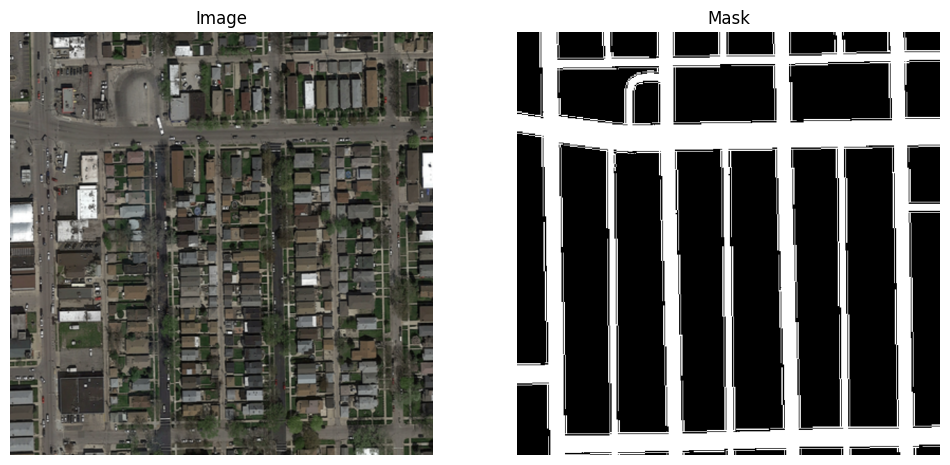

In [8]:
# Select a sample from the training dataset
image, mask = train_dataset[0]  # Change the index to visualize other samples

# Convert the image tensor to a numpy array for visualization
# Image shape is [3, 608, 608], permute to [608, 608, 3] for Matplotlib
image_np = image.permute(1, 2, 0).numpy().astype("uint8")

# Convert the mask tensor to a numpy array
mask_np = mask.numpy()

# Plot the image and mask side by side
plt.figure(figsize=(12, 6))

# Display the image
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Image")
plt.axis("off")

# Display the mask
plt.subplot(1, 2, 2)
plt.imshow(mask_np, cmap="gray")
plt.title("Mask")
plt.axis("off")

plt.show()

# Building the model
In this section, we define the model **Deeplabv3+**. As an encoder, we take **Resnet50**, and the encoder weights are initialized with some predefined values. We also define some augmentations for out dataset diversity, that we might use or not.
If we'll do, we'll have to create new **DataLoaders**


In [9]:
# Model configuration
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['background', 'road']  # Binary segmentation classes
ACTIVATION = 'sigmoid'  # Sigmoid activation for binary segmentation

# Create DeepLabV3+ model
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=1,  # Single output channel for binary segmentation
    activation=None,  # Activation (e.g., sigmoid) will be applied during training/inference
)

# Preprocessing function to normalize input for the encoder
# Matches normalization used during encoder pretraining
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)


In [10]:
import albumentations as album

def get_training_augmentation():
    return album.Compose([
        album.HorizontalFlip(p=0.5),  # Random horizontal flip
        album.VerticalFlip(p=0.5),  # Random vertical flip
        album.RandomRotate90(p=0.5),  # Random 90-degree rotation
        album.RandomBrightnessContrast(p=0.2),  # Adjust brightness/contrast
        album.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),  # Small shifts, scales, and rotations
    ])

# Reusable preprocessing function
def get_preprocessing():
    return album.Compose([album.Lambda(image=preprocessing_fn)])

# Reusable validation augmentation (if needed)
def get_validation_augmentation():
    return album.Compose([
        album.Resize(608, 608)  # Ensure consistent size for validation data
    ])

In [11]:
# Set flag to train the model or not
TRAINING = True

# Configurable parameters
learning_rate = 1e-4
EPOCHS = 25

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss function for binary segmentation
loss = torch.nn.BCEWithLogitsLoss()

# Custom Dice Score function
def dice_score(preds, targets, threshold=0.5, smooth=1e-6):
    """
    Custom implementation of Dice Score.
    Args:
        preds: Predicted probabilities or logits.
        targets: Ground truth binary masks.
        threshold: Threshold for converting probabilities to binary predictions.
        smooth: Smoothing factor to avoid division by zero.
    """
    preds = (preds > threshold).float()  # Apply threshold to predictions
    intersection = (preds * targets).sum(dim=(1, 2, 3))  # Compute intersection
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))  # Compute union
    dice = (2 * intersection + smooth) / (union + smooth)  # Compute Dice coefficient
    return dice.mean()  # Average across batch

# Define metrics as a list of functions
metrics = [dice_score]

# Define optimizer
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=learning_rate),
])

# (Optional) Define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# Load a pre-trained checkpoint (if available)
checkpoint_path = "/content/drive/MyDrive/MA1/ML_Project_2/checkpoints/best_model.pth"
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))
    print('Loaded pre-trained DeepLabV3+ model!')

# Move the model to the correct device
model = model.to(DEVICE)


In [12]:
def train_epoch(model, train_loader, optimizer, loss_fn, metrics, device):
    model.train()
    train_loss = 0
    train_dice = 0

    for batch_idx, (images, masks) in enumerate(train_loader):
        images, masks = images.to(device), masks.to(device)
        if masks.ndim == 3:  # Add channel dimension if not present
            masks = masks.unsqueeze(1)

        preds = model(images)
        loss = loss_fn(preds, masks.float())  # Ensure target is float for BCEWithLogitsLoss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        train_dice += metrics[0](preds.sigmoid(), masks)  # Compute Dice Score

        # Optional: Logging
        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f}")

    return train_loss / len(train_loader), train_dice / len(train_loader)

def valid_epoch(model, valid_loader, loss_fn, metrics, device):
    model.eval()
    valid_loss = 0
    valid_dice = 0

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(valid_loader):
            images, masks = images.to(device), masks.to(device)
            if masks.ndim == 3:  # Add channel dimension if not present
                masks = masks.unsqueeze(1)

            preds = model(images)
            loss = loss_fn(preds, masks.float())
            valid_loss += loss.item()
            valid_dice += metrics[0](preds.sigmoid(), masks)

            # Optional: Logging
            if batch_idx % 10 == 0:
                print(f"Validation Batch {batch_idx}/{len(valid_loader)} - Loss: {loss.item():.4f}")

    return valid_loss / len(valid_loader), valid_dice / len(valid_loader)

def valid_epoch(model, valid_loader, loss_fn, metrics, device):
    model.eval()
    valid_loss = 0
    valid_dice = 0

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(valid_loader):
            images, masks = images.to(device), masks.to(device)
            if masks.ndim == 3:  # Add channel dimension if not present
                masks = masks.unsqueeze(1)

            preds = model(images)
            loss = loss_fn(preds, masks.float())
            valid_loss += loss.item()
            valid_dice += metrics[0](preds.sigmoid(), masks)

            # Optional: Logging
            if batch_idx % 10 == 0:
                print(f"Validation Batch {batch_idx}/{len(valid_loader)} - Loss: {loss.item():.4f}")

    return valid_loss / len(valid_loader), valid_dice / len(valid_loader)


In [13]:
import time

# Initialize the best Dice score
best_dice = 0.0
save_path = "best_model.pth"  # Configurable save path

# Lists to retain loss and Dice score per epoch for plotting
train_losses = []
train_dice_scores = []
valid_losses = []
valid_dice_scores = []

for epoch in range(EPOCHS):
    start_time = time.time()
    print(f"Epoch {epoch + 1}/{EPOCHS} - Starting...")

    # Train the model
    train_loss, train_dice = train_epoch(
        model, train_loader, optimizer, loss, metrics, DEVICE
    )
    print(f"Train Loss: {train_loss:.4f}, Train Dice Score: {train_dice:.4f}")

    # Append training metrics
    train_losses.append(train_loss)
    train_dice_scores.append(train_dice)

    # Validate the model
    valid_loss, valid_dice = valid_epoch(
        model, valid_loader, loss, metrics, DEVICE
    )
    print(f"Valid Loss: {valid_loss:.4f}, Valid Dice Score: {valid_dice:.4f}")

    # Append validation metrics
    valid_losses.append(valid_loss)
    valid_dice_scores.append(valid_dice)

    # Save the best model
    if epoch == 0 or valid_dice > best_dice:
        best_dice = valid_dice
        torch.save(model.state_dict(), save_path)
        print(f"Best model saved at epoch {epoch + 1} with Dice Score: {best_dice:.4f}")

    # Apply learning rate scheduler (if defined)
    if lr_scheduler:
        lr_scheduler.step()

    # Log epoch duration
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch + 1} completed in {epoch_time:.2f} seconds\n")

# Now train_losses, train_dice_scores, valid_losses, and valid_dice_scores
# can be used to plot the training and validation performance.


Epoch 1/25 - Starting...
Batch 0/32 - Loss: 0.6851
Batch 10/32 - Loss: 0.5930
Batch 20/32 - Loss: 0.4663
Batch 30/32 - Loss: 0.4056
Train Loss: 0.5313, Train Dice Score: 0.5622
Validation Batch 0/4 - Loss: 0.5619
Valid Loss: 0.5508, Valid Dice Score: 0.6900
Best model saved at epoch 1 with Dice Score: 0.6900
Epoch 1 completed in 19.89 seconds

Epoch 2/25 - Starting...
Batch 0/32 - Loss: 0.3992
Batch 10/32 - Loss: 0.3390
Batch 20/32 - Loss: 0.3031
Batch 30/32 - Loss: 0.2892
Train Loss: 0.3187, Train Dice Score: 0.7610
Validation Batch 0/4 - Loss: 0.3158
Valid Loss: 0.2825, Valid Dice Score: 0.8008
Best model saved at epoch 2 with Dice Score: 0.8008
Epoch 2 completed in 19.04 seconds

Epoch 3/25 - Starting...
Batch 0/32 - Loss: 0.2471
Batch 10/32 - Loss: 0.2503
Batch 20/32 - Loss: 0.2297
Batch 30/32 - Loss: 0.2247
Train Loss: 0.2452, Train Dice Score: 0.8094
Validation Batch 0/4 - Loss: 0.2773
Valid Loss: 0.2500, Valid Dice Score: 0.8037
Best model saved at epoch 3 with Dice Score: 0.803

KeyboardInterrupt: 

In [14]:
def visualize_with_model_no_resize(model, model_path, image_path, device):
    """
    Visualizes the input image next to its predicted mask without resizing or normalizing the image.

    Args:
        model (torch.nn.Module): Preloaded model.
        model_path (str): Path to the saved best model.
        image_path (str): Path to the input image.
        device (torch.device): The device to run the model on.

    Returns:
        None
    """
    # Load the weights into the existing model
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Load the image
    image = cv2.imread(image_path)  # Load the image using OpenCV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    original_image = image.copy()  # Keep the original for visualization

    # Convert image to a tensor without resizing or normalization
    input_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float().to(device)  # CHW format, add batch dim

    # Predict the mask
    with torch.no_grad():
        output = model(input_tensor)
        pred_mask = torch.sigmoid(output).squeeze(0).squeeze(0).cpu().numpy()  # Convert to numpy array
        pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Threshold to binary mask

    # Visualize the input image and predicted mask
    plt.figure(figsize=(6, 3))

    # Display the input image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.axis('off')
    plt.title("Input Image")

    # Display the predicted mask
    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask, cmap="gray")
    plt.axis('off')
    plt.title("Predicted Mask")

    plt.tight_layout()
    plt.show()


Processing image: test_3.png


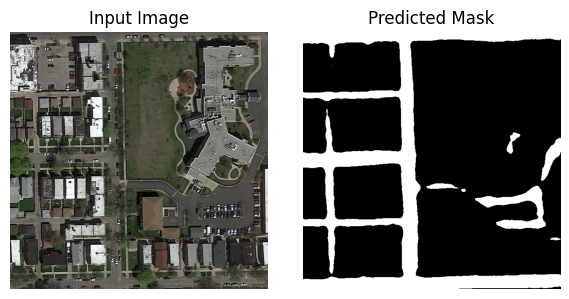

Processing image: test_29.png


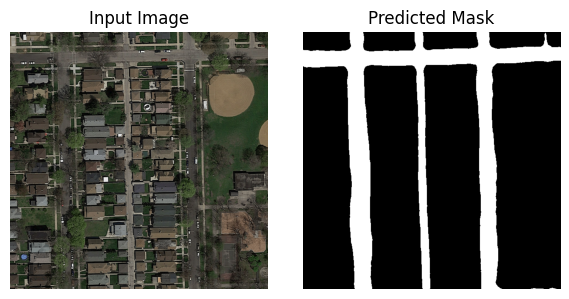

Processing image: test_1.png


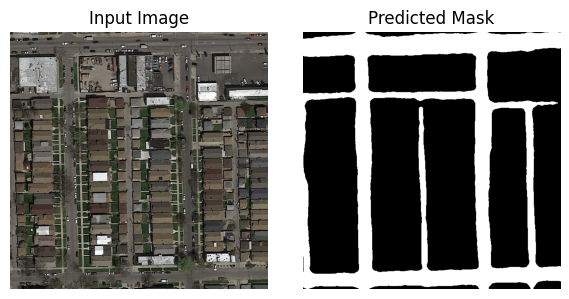

Processing image: test_24.png


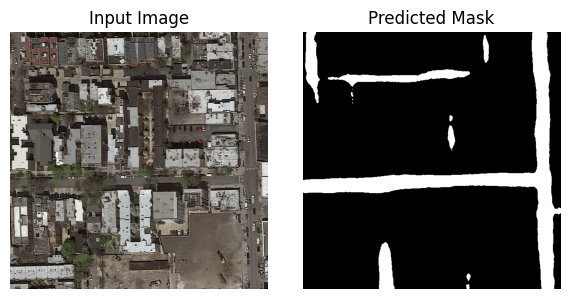

Processing image: test_11.png


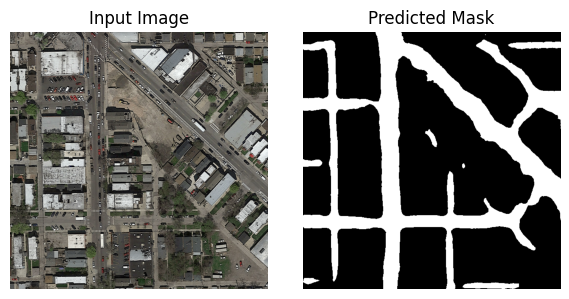

Processing image: test_21.png


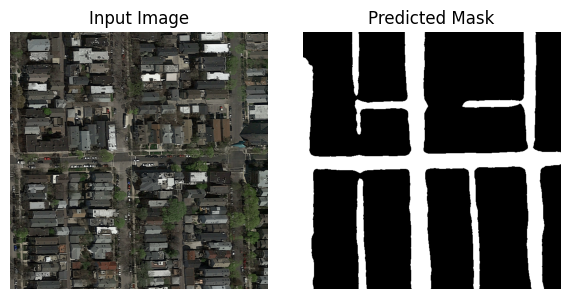

Processing image: test_43.png


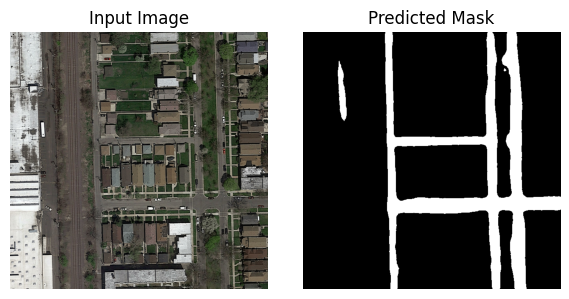

Processing image: test_4.png


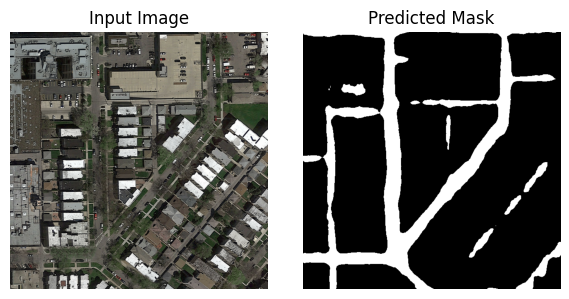

Processing image: test_32.png


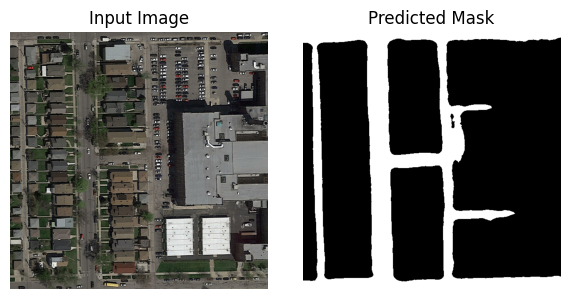

Processing image: test_28.png


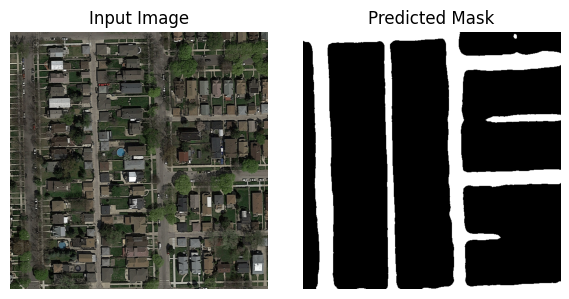

Processing image: test_9.png


KeyboardInterrupt: 

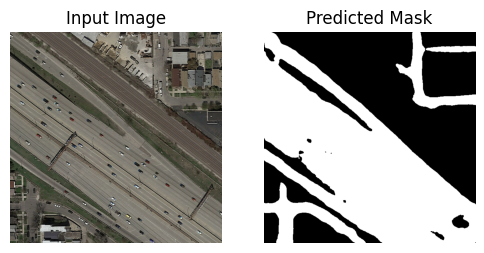

In [15]:
import os

# Example usage
image_folder_path = "/content/drive/MyDrive/MA1/ML_Project_2/test_set_images"  # Replace with the folder containing PNG images
model_path = "/content/best_model.pth"  # Replace with your saved model path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Iterate through all PNG files in the folder
for image_file in os.listdir(image_folder_path):
    if image_file.endswith(".png"):  # Check for PNG files
        image_path = os.path.join(image_folder_path, image_file)
        print(f"Processing image: {image_file}")
        visualize_with_model_no_resize(model, model_path, image_path, device)


# Creating submission

In [16]:
import cv2
import torch
import numpy as np
import os

def save_mask_to_directory(model, model_path, image_path, device, i, directory_path):
    """
    Saves the predicted mask to a file in the specified directory.

    Args:
        model (torch.nn.Module): Preloaded model.
        model_path (str): Path to the saved best model.
        image_path (str): Path to the input image.
        device (torch.device): The device to run the model on.
        i (int): Index to name the output file.
        directory_path (str): Path to the directory to store the mask file.

    Returns:
        None
    """
    # Load the weights into the existing model
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Load the image
    image = cv2.imread(image_path)  # Load the image using OpenCV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

    # Convert image to a tensor without resizing or normalization
    input_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float().to(device)  # CHW format, add batch dim

    # Predict the mask
    with torch.no_grad():
        output = model(input_tensor)
        pred_mask = torch.sigmoid(output).squeeze(0).squeeze(0).cpu().numpy()  # Convert to numpy array
        pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Threshold to binary mask

    # Ensure the labels are 0 or 1
    pred_mask = (pred_mask > 0).astype(np.uint8)  # Enforce binary values

    # Ensure the directory exists
    os.makedirs(directory_path, exist_ok=True)

    # Define the output file path
    output_file_path = os.path.join(directory_path, f"mask_test_{i}.png")

    # Save the mask as a file
    cv2.imwrite(output_file_path, pred_mask * 255)  # Save the binary mask directly (0 and 1)
    print(f"Mask saved at: {output_file_path}")


In [17]:
# Example usage
image_folder_path = "/content/drive/MyDrive/MA1/ML_Project_2/test_set_images"  # Replace with the folder containing PNG images
model_path = "/content/best_model.pth"  # Replace with your saved model path
masks_directory = "/content/masks"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Iterate through all PNG files in the folder
for i in range(1,51):
      image_file = f"test_{i}.png"
      image_path = os.path.join(image_folder_path, image_file)
      save_mask_to_directory(model,model_path,image_path,device,i,masks_directory)

Mask saved at: /content/masks/mask_test_1.png
Mask saved at: /content/masks/mask_test_2.png
Mask saved at: /content/masks/mask_test_3.png
Mask saved at: /content/masks/mask_test_4.png
Mask saved at: /content/masks/mask_test_5.png
Mask saved at: /content/masks/mask_test_6.png
Mask saved at: /content/masks/mask_test_7.png
Mask saved at: /content/masks/mask_test_8.png
Mask saved at: /content/masks/mask_test_9.png
Mask saved at: /content/masks/mask_test_10.png
Mask saved at: /content/masks/mask_test_11.png
Mask saved at: /content/masks/mask_test_12.png
Mask saved at: /content/masks/mask_test_13.png
Mask saved at: /content/masks/mask_test_14.png
Mask saved at: /content/masks/mask_test_15.png
Mask saved at: /content/masks/mask_test_16.png
Mask saved at: /content/masks/mask_test_17.png
Mask saved at: /content/masks/mask_test_18.png
Mask saved at: /content/masks/mask_test_19.png
Mask saved at: /content/masks/mask_test_20.png
Mask saved at: /content/masks/mask_test_21.png
Mask saved at: /conten

In [19]:
import os
import numpy as np
import matplotlib.image as mpimg
import re

# Set threshold for foreground detection
foreground_threshold = 0.25  # percentage of pixels > 1 required to assign a foreground label to a patch

# Define a function to assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    return 1 if df > foreground_threshold else 0

# Read a single image and convert it to submission strings
def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(image_filename)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield "{:03d}_{}_{},{}".format(img_number, j, i, label)

# Convert mask images into a submission CSV file
def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn))

# Main block for Colab
if __name__ == '__main__':
    # Output submission filename
    submission_filename = 'deeplabv3_submission.csv'
    # Define image filenames (mask_test_1.png to mask_test_50.png)
    image_filenames = []
    working_directory = "/content/masks"
    for i in range(1, 51):
        image_filename = os.path.join(working_directory,f'mask_test_{i}.png')  # Update filename format
        if os.path.exists(image_filename):  # Check if file exists
            print(f"Processing {image_filename}")
            image_filenames.append(image_filename)
        else:
            print(f"Warning: {image_filename} not found!")

    # Generate the submission file
    masks_to_submission(submission_filename, *image_filenames)
    print(f"Submission file '{submission_filename}' created successfully!")


Processing /content/masks/mask_test_1.png
Processing /content/masks/mask_test_2.png
Processing /content/masks/mask_test_3.png
Processing /content/masks/mask_test_4.png
Processing /content/masks/mask_test_5.png
Processing /content/masks/mask_test_6.png
Processing /content/masks/mask_test_7.png
Processing /content/masks/mask_test_8.png
Processing /content/masks/mask_test_9.png
Processing /content/masks/mask_test_10.png
Processing /content/masks/mask_test_11.png
Processing /content/masks/mask_test_12.png
Processing /content/masks/mask_test_13.png
Processing /content/masks/mask_test_14.png
Processing /content/masks/mask_test_15.png
Processing /content/masks/mask_test_16.png
Processing /content/masks/mask_test_17.png
Processing /content/masks/mask_test_18.png
Processing /content/masks/mask_test_19.png
Processing /content/masks/mask_test_20.png
Processing /content/masks/mask_test_21.png
Processing /content/masks/mask_test_22.png
Processing /content/masks/mask_test_23.png
Processing /content/